# 1. Import models

In [1]:
# for loading and preprocessing the data
import torch
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

# for training the model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model

# for evaluating classification model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,f1_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Load data

In [2]:
import os

for dirname, _, filenames in os.walk('TFIDFInput'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.width',1000000)
pd.set_option('display.max_columns', 500)

score_df = pd.DataFrame(columns={'Model Description','Score'})
# Any results you write to the current directory are saved as output.

train = pd.read_csv("TFIDFInput/train_added.csv", encoding = 'CP949')
test = pd.read_csv("TFIDFInput/test.csv")

TFIDFInput/train_added.csv
TFIDFInput/train.csv
TFIDFInput/sample_submission.csv
TFIDFInput/test.csv


## 2.1 Check Data

In [3]:
print(train.shape)
print(train.isnull().any())

(8013, 5)
id          False
keyword      True
location     True
text        False
target      False
dtype: bool


In [4]:
print(test.shape)
print(test.isnull().any())

(3263, 5)
id          False
keyword      True
location     True
text        False
target      False
dtype: bool


## 2.2 Visualize data

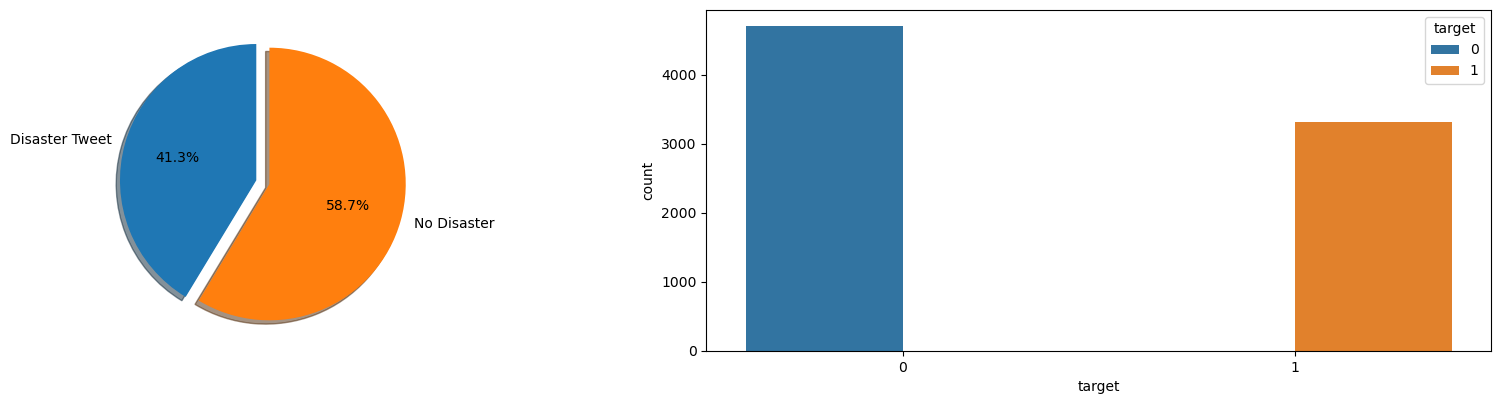

In [5]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

labels = ['Disaster Tweet','No Disaster']
size = [train['target'].mean()*100,abs(1-train['target'].mean())*100]
explode = (0, 0.1)

#ig1,ax1 = plt.subplots()
axes[0].pie(size,labels=labels,explode=explode,shadow=True, 
            startangle=90,autopct='%1.1f%%')
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])
plt.show()

# 3. Training

## 3.3 Processing text

In [6]:
# data prepocessing with regrex

def remove_URL(text): # remove url pattern in text
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text): # remove html pattern in text
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return html.sub(r'', text)
    #return re.sub(html, '', text)

def remove_punct(text): # remove punctuation in text: (;, ', ", :, ., , etc..)
  table = str.maketrans('', '', string.punctuation)
  return text.translate(table)

In [7]:
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    return text


In [8]:
def massage_text(text):  # 이건 안하는 게 성능 향상에 좋다.
    import re
    from nltk.corpus import stopwords
    ## remove anything other then characters and put everything in lowercase
    tweet = re.sub("[^a-zA-Z]", ' ', text)
    tweet = tweet.lower()
    tweet = tweet.split()
    
    from nltk.stem import WordNetLemmatizer
    lem = WordNetLemmatizer()
    tweet = [lem.lemmatize(word) for word in tweet
             if word not in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    return tweet
    print('--here goes nothing')
    print(text)
    print(tweet)


In [9]:
train['clean_text'] = train['text'].apply(lambda x: remove_URL(x))
train['clean_text'] = train['text'].apply(lambda x: remove_html(x))
train['clean_text'] = train['text'].apply(lambda x: remove_punct(x))

test['clean_text'] = test['text'].apply(lambda x: remove_URL(x))
test['clean_text'] = test['text'].apply(lambda x: remove_html(x))
test['clean_text'] = test['text'].apply(lambda x: remove_punct(x))

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

# train['clean_text'] = train['text'].apply(massage_text)
# test['clean_text'] = test['text'].apply(massage_text)  

## 3.4 Check processed data

In [10]:
train.iloc[-10:-1][['text','clean_text']]

,text,clean_text
8003,Nuclear the SAFEST most RELIABLE energy source...,nuclear the safest most reliable energy source...
8004,Share Tokyo2020 will be held on the irradiated...,share tokyo2020 will be held on the irradiated...
8005,Hedge funds snap up Uranium in bet on GreenEne...,hedge funds snap up uranium in bet on greenene...
8006,Led by France 10x EU countries call on Brussel...,led by france 10x eu countries call on brussel...
8007,France bets on more Nuclear power in face of E...,france bets on more nuclear power in face of e...
8008,guardian Go nuclear and solar,guardian go nuclear and solar
8009,It is beginning nuclear,it is beginning nuclear
8010,GB Grid Nuclear is generating 397GW 1759 out o...,gb grid nuclear is generating 397gw 1759 out o...
8011,Taiwan separatists are US puppets USA built th...,taiwan separatists are us puppets usa built th...


# 4. Training with processed data

## 4.1 TFIDF  test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train['clean_text'], train['target'], test_size=0.1, random_state=20)

# # Apply Tfidf tranformation except message_text() process
# vector = [
#     TfidfVectorizer(), # F1 score: 0.7584059775840598
#     TfidfVectorizer(max_features = 1000), # F1 score: 0.7444514901712113
#     TfidfVectorizer(max_features = 2000), # F1 score: 0.7542857142857142
#     TfidfVectorizer(max_features = 3000), #  F1 score: 0.7531645569620253
#     TfidfVectorizer(max_features = 10000), # F1 score: 0.7626800250469631 --> best
#     TfidfVectorizer(max_features = 20000) # F1 score: 0.7584059775840598
#     TfidfVectorizer(ngram_range =(1,2)), 
#     TfidfVectorizer(ngram_range =(1,3))
# ]

# # Apply Tfidf tranformation except message_text() process + split tune
# # split(test_size=0.2, stratify=train['target'], random_state=20)
# vector = [
#     TfidfVectorizer(), # F1 score: 0.7348912167606769
#     TfidfVectorizer(max_features = 1000), # F1 score: 0.7235099337748343
#     TfidfVectorizer(max_features = 2000), # F1 score: 0.7358024691358025
#     TfidfVectorizer(max_features = 3000), #  F1 score: 0.734860883797054
#     TfidfVectorizer(max_features = 10000), # F1 score: 0.7408013082583811
#     TfidfVectorizer(max_features = 20000) # F1 score: 0.7354838709677419
# ]


# # Apply Tfidf tranformation except message_text() process + split tune
# # split(test_size=0.2, random_state=20)
# vector = [
#     TfidfVectorizer(), # F1 score: F1 score: 0.7630331753554502   --> best
#     TfidfVectorizer(max_features = 20000) # F1 score: 0.7630331753554502 --> best
# ]

# Apply Tfidf tranformation except message_text() process + split tune
# split(test_size=0.1, random_state=20)
vector = [
#     TfidfVectorizer(), # F1 score: F1 score: 0.7682737169517885  
    TfidfVectorizer(max_features = 20000), # F1 score: 0.7701863354037266 --> best
#     TfidfVectorizer(max_features = 30000)  # F1 score: 0.7682737169517885
]

# # Apply Tfidf tranformation except message_text() process + split tune
# # split(test_size=0.15, random_state=20)
# vector = [
#     TfidfVectorizer(), # F1 score: 0.7643979057591623
#     TfidfVectorizer(max_features = 10000), # F1 score: 0.7660020986358866
#     TfidfVectorizer(max_features = 20000), # F1 score: 0.7635983263598327
#     TfidfVectorizer(max_features = 30000)  # F1 score: 0.7643979057591623
# ]

# # Apply Tfidf tranformation except message_text() process + split tune
# # split(test_size=0.05, random_state=20)
# vector = [
#     TfidfVectorizer(), # F1 score: F1 score: 0.7658227848101266
# ]

# # Apply Tfidf tranformation except message_text(), clean_text() process
# vector = [
#     TfidfVectorizer(), # F1 score: 0.7615433270082226
#     TfidfVectorizer(max_features = 1000), # F1 score: 0.7399872854418309
#     TfidfVectorizer(max_features = 2000), # F1 score: 0.7523629489603024
#     TfidfVectorizer(max_features = 3000), #  F1 score: 0.7504714016341923
#     TfidfVectorizer(max_features = 10000) # F1 score: 0.7574039067422811
# ]

# X_train_vector = vector.transform(X_train)
# X_test_vector  = vector.transform(X_test)


# 4.2 Model test

In [12]:
## pre processed data for all method
# MLA = [
#     linear_model.RidgeClassifierCV(alphas=[1e-3]),     # F1 score: 0.7113702623906706
#     linear_model.RidgeClassifierCV(alphas=[1e-2]),     # F1 score: 0.7109283196239718
#     linear_model.RidgeClassifierCV(alphas=[1e-1]),     # F1 score: 0.7368421052631579
#     linear_model.RidgeClassifierCV(alphas=[1]),        # F1 score: 0.741738066095471
#     linear_model.RidgeClassifierCV(normalize=True),    # F1 score: 0.7209154481881755
#     linear_model.RidgeClassifierCV(cv=5),              # F1 score: 0.7417380660954712
#     linear_model.RidgeClassifierCV(alphas=[1], cv=5),  # F1 score: 0.7417380660954712
#     linear_model.RidgeClassifierCV(alphas=[1], normalize=True),  #F1 score: 0.7209154481881755
#     linear_model.RidgeClassifierCV(alphas=[1], cv=10), # F1 score: 0.7417380660954712
#     linear_model.RidgeClassifierCV(alphas=[10], cv=5) # F1 score: 0.707057256990679
# ]

## pre processed data except message_text()
# MLA = [
#     linear_model.RidgeClassifierCV(alphas=[1e-3]),     # F1 score: 0.7272727272727273
#     linear_model.RidgeClassifierCV(alphas=[1e-2]),     # F1 score: 0.7326615293420273
#     linear_model.RidgeClassifierCV(alphas=[1e-1]),     # F1 score: 0.7485029940119761
#     linear_model.RidgeClassifierCV(alphas=[1])        # F1 score: 0.7584059775840598 -> best
#     linear_model.RidgeClassifierCV(normalize=True),    # F1 score: 0.7189119170984455
#     linear_model.RidgeClassifierCV(alphas=[1], cv=5),  # F1 score: 0.7584059775840598
#     linear_model.RidgeClassifierCV(alphas=[1], normalize=True),  # 0.7189119170984455
#     linear_model.RidgeClassifierCV(alphas=[10], cv=5) # F1 score: 0.7264276228419655
# ]


In [13]:
import time
import pickle

RES_columns = []
RES_compare = pd.DataFrame(columns = RES_columns)

RES_compare.loc[0,'Model used'] = "Initial"
RES_compare.loc[0, 'F1-score'] = "0"
RES_compare.loc[0, 'AUC'] = "0"

row_index = 1
model = linear_model.RidgeClassifierCV(alphas=[1])  

for vec in vector: 
    vec.fit(X_train)
    X_train_vector = vec.transform(X_train)
    X_test_vector  = vec.transform(X_test)

    predicted = model.fit(X_train_vector.todense(), y_train).predict(X_test_vector.todense())
    f1 = f1_score(y_test,predicted)
    auroc = roc_auc_score(y_test,predicted)
    
    RES_name = model.__class__.__name__
    RES_compare.loc[row_index,'Model used'] = RES_name
    RES_compare.loc[row_index, 'F1-score'] = f1
    RES_compare.loc[row_index, 'AUC'] = auroc
    
    print(f"Model: {row_index:03d}, F1 score: {RES_compare.loc[row_index, 'F1-score']}")
    row_index+=1   
          
#     filename = f"./weights/model{row_index:03d}-{time.strftime('%Y-%m-%d-%H')}-F1{int(f1*1e5):06d}.sav"
#     pickle.dump(model, open(filename, 'wb'))
          

Model: 001, F1 score: 0.7701863354037266


# 5. Conclusion

### TFIDF를 적용할 때, feature를 20000개로 제한
### 데이터에 message_text() process만 적용하지 않음
### 데이터를 test_size=0.1로 split
## 했을 때 가장 좋은 성능을 보인다.

test_size: 테스트 셋 구성의 비율.
    - 0.1은 전체 데이터 셋의 10%를 test (validation) 셋으로 지정하겠다는 의미임. 
    - default 값은 0.25